In [2]:
import sympy as sym
import numpy as np
import scipy as sp
import ipywidgets as ip
import ipywidgets as widgets
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

In [3]:
r_s, t = sym.symbols('r_s t')
rn, phin, r, phi = sym.symbols('rn phin r phi', cls = sym.Function)


# ------ Newtonian Diff Equations Data Generating ---------

rn = rn(t)
phin = phin(t)

rn_d = sym.diff(rn, t)
phin_d = sym.diff(phin, t)

rn_dd = sym.diff(rn, t, t)
phin_dd = sym.diff(phin, t, t)

diff_rn = - (1)/(rn**2) + rn*(phin_d**2)
diff_phin = -(2*rn_d*phin_d)/(rn)


r = r(t)
phi = phi(t)

r_d = sym.diff(r, t)
phi_d = sym.diff(phi, t)


r_dd = sym.diff(r, t, t)
phi_dd = sym.diff(phi, t, t)

diff_r = - (r_s)/(2*r**2) + r*phi_d**2 - (3/2)*r_s*phi_d**2
diff_phi = -(2*r_d*phi_d)/(r)

n_dz1dt_f = sym.lambdify((t, rn, rn_d, phin_d), diff_rn)
n_dz2dt_f = sym.lambdify((t, rn, rn_d, phin_d), diff_phin)
n_drdt_f = sym.lambdify(rn_d, rn_d)
n_dthetadt_f = sym.lambdify(phin_d, phin_d)

dz1dt_f = sym.lambdify((t, r_s, r, r_d, phi_d), diff_r)
dz2dt_f = sym.lambdify((t, r_s, r, r_d, phi_d), diff_phi)
drdt_f = sym.lambdify(r_d, r_d)
dthetadt_f = sym.lambdify(phi_d, phi_d)

def dSdt(S, tau, r_s):
    r, z1, phi, z2 = S
    return [drdt_f(z1),
           dz1dt_f(t, r_s, r, z1, z2),
           dthetadt_f(z2),
           dz2dt_f(t, r_s, r, z1, z2)]



def dSndt(S, t_n):
    rn, z1, phin, z2 = S
    return [n_drdt_f(z1),
           n_dz1dt_f(t, rn, z1, z2),
           n_dthetadt_f(z2),
           n_dz2dt_f(t, rn, z1, z2)]

t = np.arange(0, 3000, 3)

# Newton Initial Conditions

rn0 = 16
drn0 = -0.21
pn0 = 0
dpn0 = 0.01
Sn0 = [rn0, drn0, pn0, dpn0]

# Einstein Initial Conditions

delta = 0.09

r_s = 1
r0 = 10
dr0 = 0
p0 = 0
dp_circular = np.sqrt(1/(2*r0 - 3))/r0
dp0 = dp_circular*(1 + delta)
S0 = [r0, dr0, p0, dp0]
args = (r_s,)

ansn = integrate.odeint(func = dSndt, y0 = Sn0 ,t = t)
ans = integrate.odeint(func = dSdt, y0 = S0 ,t = t, args = args)

rnd = ansn.T[0]
drndtd = ansn.T[1]
phinad = ansn.T[2]
dphindtd = ansn.T[3]
xn = rnd*np.cos(phinad)
yn = rnd*np.sin(phinad)

rd = ans.T[0]
drdtd = ans.T[1]
thetad = ans.T[2]
dthetadtd = ans.T[3]
x = rd*np.cos(thetad)
y = rd*np.sin(thetad)

def BigBoyPlot(r0, delta, rn0, drn0, pn0, dpn0):
    t = np.arange(0, 3000, 3)
    ansn = integrate.odeint(func = dSndt, y0 = [rn0, drn0, pn0, dpn0] , t = t)
    rnd = ansn.T[0]
    xn = ansn.T[0]*np.cos(ansn.T[2])
    yn = ansn.T[0]*np.sin(ansn.T[2])
    
    r_s = 1
    args = (r_s,)
    ans = integrate.odeint(func = dSdt, y0 = [r0, 0, 0, (np.sqrt(1/(2*r0 - 3))/r0)*(1 + delta)] ,t = t, args = args)
    rd = ans.T[0]
    x1 = ans.T[0]*np.cos(ans.T[2])
    y1 = ans.T[0]*np.sin(ans.T[2])

    fig, ax = plt.subplots(2, 2, figsize = (16,10), gridspec_kw={'height_ratios': [3, 1]})

    ax[0,0].set_facecolor('w')
    ax[0,0].set_title('Schwarzschild Orbit', fontsize=20)
    ax[0,0].grid(linestyle = '--', linewidth = 1)
    ax[0,0].annotate("Black Hole ", (-3, -3))
    ax[0,0].set_ylim(round(min(y1)) - 1, round(max(y1)) + 1)
    ax[0,0].set_xlim(round(min(x1)) - 1, round(max(y1)) + 1)

    l = (S0[0]**2)*S0[3]
    x2 = rd
    y2 = 1/2 + (l**2/(2*x2**2)) - (r_s)/(2*x2) - (r_s*l**2)/(2*x2**3)

    x3 = np.linspace(1, max(rd) + 10, 100)
    y3 = 1/2 + (l**2/(2*x3**2)) - (r_s)/(2*x3) - (r_s*l**2)/(2*x3**3)

    ax[1,0].set_facecolor('w')
    ax[1,0].set_xlabel('Distance from centre of Black Hole: r')
    ax[1,0].set_title('Schwarzschild Black Hole Potential')
    ax[1,0].grid(linestyle = '--', linewidth = 1)
    ax[1,0].set_ylim(min(y2) - 0.01, max(y3) + 0.01)
    ax[1,0].set_xlim(0, max(x2)*(1+0.1))
    
    
    ax[0,1].set_facecolor('w')
    ax[0,1].set_title('Newtonian Orbit', fontsize=20)
    ax[0,1].grid(linestyle = '--', linewidth = 1)
    ax[0,1].annotate("Star", (-0.7, -1.7))
    ax[0,1].set_ylim(round(min(yn)) - 1, round(max(yn)) + 1)
    ax[0,1].set_xlim(round(min(xn)) - 1, round(max(xn)) + 1)

    
    L = (Sn0[0]**2)*Sn0[3]
    rn2 = rnd
    vn2 = (L**2)/(2*rn2**2) - 1/(rn2)
    rn1 = np.linspace(1, max(rnd)+10, 100)
    vn1 = (L**2)/(2*rn1**2) - 1/(rn1)

    ax[1,1].set_facecolor('w')
    ax[1,1].set_xlabel('Distance from centre of Sun: r')
    ax[1,1].set_title('Newtonian Gravitational Potential')
    ax[1,1].grid(linestyle = '--', linewidth = 1)
    ax[1,1].set_ylim(min(vn1) - 0.1, max(vn2) + 1)
    ax[1,1].set_xlim(0, max(rn2)*(1 + 0.1))


    ax[0,0].plot(x1,y1, '--',color = 'k', lw=0.8)
    ax[0,0].plot(0,0, 'o',color = 'k', lw=20),ax[1,0].plot(x3,y3, color = 'k', lw = 2)
    ax[1,0].plot(x2,y2, color = 'c', lw = 3)
    ax[0,1].plot(0,0, 'o',color='y', lw=20,)
    ax[0,1].plot(xn,yn, '--',color = 'k', lw=0.8,)
    ax[1,1].plot(rn1, vn1, color = 'k', lw=2)
    ax[1,1].plot(rn2, vn2, color = 'c', lw=3)


In [41]:
r_s, t = sym.symbols('r_s t')
rn, phin, r, phi = sym.symbols('rn phin r phi', cls = sym.Function)


# ------ Newtonian Diff Equations Data Generating ---------

rn = rn(t)
phin = phin(t)

rn_d = sym.diff(rn, t)
phin_d = sym.diff(phin, t)

rn_dd = sym.diff(rn, t, t)
phin_dd = sym.diff(phin, t, t)

diff_rn = - (1)/(rn**2) + rn*(phin_d**2)
diff_phin = -(2*rn_d*phin_d)/(rn)


r = r(t)
phi = phi(t)

r_d = sym.diff(r, t)
phi_d = sym.diff(phi, t)


r_dd = sym.diff(r, t, t)
phi_dd = sym.diff(phi, t, t)

diff_r = - (r_s)/(2*r**2) + r*phi_d**2 - (3/2)*r_s*phi_d**2
diff_phi = -(2*r_d*phi_d)/(r)

n_dz1dt_f = sym.lambdify((t, rn, rn_d, phin_d), diff_rn)
n_dz2dt_f = sym.lambdify((t, rn, rn_d, phin_d), diff_phin)
n_drdt_f = sym.lambdify(rn_d, rn_d)
n_dthetadt_f = sym.lambdify(phin_d, phin_d)

dz1dt_f = sym.lambdify((t, r_s, r, r_d, phi_d), diff_r)
dz2dt_f = sym.lambdify((t, r_s, r, r_d, phi_d), diff_phi)
drdt_f = sym.lambdify(r_d, r_d)
dthetadt_f = sym.lambdify(phi_d, phi_d)

def dSdt(S, tau, r_s):
    r, z1, phi, z2 = S
    return [drdt_f(z1),
           dz1dt_f(t, r_s, r, z1, z2),
           dthetadt_f(z2),
           dz2dt_f(t, r_s, r, z1, z2)]



def dSndt(S, t_n):
    rn, z1, phin, z2 = S
    return [n_drdt_f(z1),
           n_dz1dt_f(t, rn, z1, z2),
           n_dthetadt_f(z2),
           n_dz2dt_f(t, rn, z1, z2)]

t = np.arange(0, 3000, 3)

# Newton Initial Conditions

rn0 = 16
drn0 = -0.21
pn0 = 0
dpn0 = 0.01
Sn0 = [rn0, drn0, pn0, dpn0]

# Einstein Initial Conditions

delta = 0.17

r_s = 1
r0 = 5.9
dr0 = 0
p0 = 0
dp_circular = np.sqrt(1/(2*r0 - 3))/r0
dp0 = dp_circular*(1 + delta)
S0 = [r0, dr0, p0, dp0]
args = (r_s,)


ansn = integrate.odeint(func = dSndt, y0 = Sn0 ,t = t)
ans = integrate.odeint(func = dSdt, y0 = S0 ,t = t, args = args)

rnd = ansn.T[0]
drndtd = ansn.T[1]
phinad = ansn.T[2]
dphindtd = ansn.T[3]
xn = rnd*np.cos(phinad)
yn = rnd*np.sin(phinad)

rd = ans.T[0]
drdtd = ans.T[1]
thetad = ans.T[2]
dthetadtd = ans.T[3]
x = rd*np.cos(thetad)
y = rd*np.sin(thetad)

def BigBoyPlot(r0, delta, rn0, drn0, pn0, dpn0):
    
    t = np.arange(0, 3000, 3)
    ansn = integrate.odeint(func = dSndt, y0 = [rn0, drn0, pn0, dpn0] , t = t)
    rnd = ansn.T[0]
    xn = ansn.T[0]*np.cos(ansn.T[2])
    yn = ansn.T[0]*np.sin(ansn.T[2])
    
    r_s = 1
    args = (r_s,)
    ans = integrate.odeint(func = dSdt, y0 = [r0, 0, 0, (np.sqrt(1/(2*r0 - 3))/r0)*(1 + delta)] ,t = t, args = args)
    rd = ans.T[0]
    x1 = ans.T[0]*np.cos(ans.T[2])
    y1 = ans.T[0]*np.sin(ans.T[2])

    fig, ax = plt.subplots(2, 2, figsize = (16,10), gridspec_kw={'height_ratios': [3, 1]})

    ax[0,0].set_facecolor('w')
    ax[0,0].set_title('Schwarzschild Orbit', fontsize=20)
    ax[0,0].grid(linestyle = '--', linewidth = 1)
    ax[0,0].annotate("Black Hole ", (-3, -3))
    ax[0,0].set_ylim(round(min(y1)) - 1, round(max(y1)) + 1)
    ax[0,0].set_xlim(round(min(x1)) - 1, round(max(y1)) + 1)

    l = (S0[0]**2)*S0[3]
    x2 = rd
    y2 = 1/2 + (l**2/(2*x2**2)) - (r_s)/(2*x2) - (r_s*l**2)/(2*x2**3)

    x3 = np.linspace(1, max(rd) + 10, 100)
    y3 = 1/2 + (l**2/(2*x3**2)) - (r_s)/(2*x3) - (r_s*l**2)/(2*x3**3)

    ax[1,0].set_facecolor('w')
    ax[1,0].set_xlabel('Distance from centre of Black Hole: r')
    ax[1,0].set_title('Schwarzschild Black Hole Potential')
    ax[1,0].grid(linestyle = '--', linewidth = 1)
    ax[1,0].set_ylim(min(y2) - 0.01, max(y3) + 0.01)
    ax[1,0].set_xlim(0, max(x2)*(1+0.1))
    
    
    ax[0,1].set_facecolor('w')
    ax[0,1].set_title('Newtonian Orbit', fontsize=20)
    ax[0,1].grid(linestyle = '--', linewidth = 1)
    ax[0,1].annotate("Star", (-0.7, -1.7))
    ax[0,1].set_ylim(round(min(yn)) - 1, round(max(yn)) + 1)
    ax[0,1].set_xlim(round(min(xn)) - 1, round(max(xn)) + 1)

    
    L = (Sn0[0]**2)*Sn0[3]
    rn2 = rnd
    vn2 = (L**2)/(2*rn2**2) - 1/(rn2)
    rn1 = np.linspace(1, max(rnd)+10, 100)
    vn1 = (L**2)/(2*rn1**2) - 1/(rn1)

    ax[1,1].set_facecolor('w')
    ax[1,1].set_xlabel('Distance from centre of Sun: r')
    ax[1,1].set_title('Newtonian Gravitational Potential')
    ax[1,1].grid(linestyle = '--', linewidth = 1)
    ax[1,1].set_ylim(min(vn1) - 0.1, max(vn2) + 1)
    ax[1,1].set_xlim(0, max(rn2)*(1 + 0.1))


    ax[0,0].plot(x1,y1, '--',color = 'k', lw=0.8)
    ax[0,0].plot(0,0, 'o',color = 'k', lw=20),ax[1,0].plot(x3,y3, color = 'k', lw = 2)
    ax[1,0].plot(x2,y2, color = 'c', lw = 3)
    ax[0,1].plot(0,0, 'o',color='y', lw=20,)
    ax[0,1].plot(xn,yn, '--',color = 'k', lw=0.8,)
    ax[1,1].plot(rn1, vn1, color = 'k', lw=2)
    ax[1,1].plot(rn2, vn2, color = 'c', lw=3)
    
ip.interact(BigBoyPlot,
            r0=widgets.FloatSlider(min=3, max=20, step=0.1),
           delta=widgets.FloatSlider(min=0, max=1, step=0.01),
           rn0=widgets.FloatSlider(min=3, max=20, step=1),
            drn0=widgets.FloatSlider(min=0, max=0.5, step=0.01),
            pn0=widgets.FloatSlider(min=0.01, max=0.5, step=0.01),
            dpn0=widgets.FloatSlider(min=0.01, max=0.5, step=0.01))

interactive(children=(FloatSlider(value=3.0, description='r0', max=20.0, min=3.0), FloatSlider(value=0.0, desc…

<function __main__.BigBoyPlot(r0, delta, rn0, drn0, pn0, dpn0)>

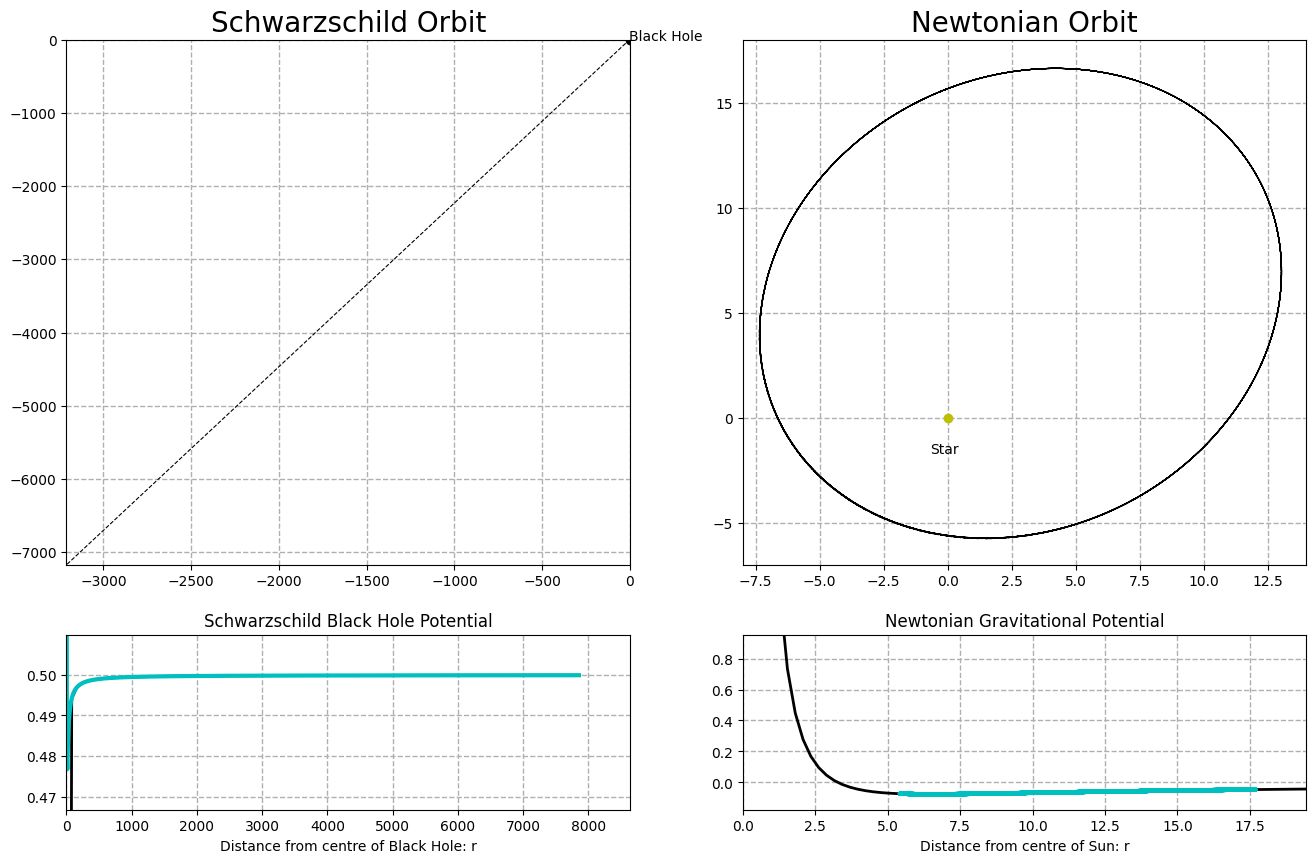

In [50]:
BigBoyPlot(1.6, 1, 12, 0.15, 0.14, 0.02)

/var/folders/1g/_127qcc13ll334lvd9yl9vdc0000gn/T/ipykernel_19952/486060473.py:140: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ln5.set_data(x2[i], y2[i])
/var/folders/1g/_127qcc13ll334lvd9yl9vdc0000gn/T/ipykernel_19952/486060473.py:151: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ln10.set_data(rn2[i], vn2[i])


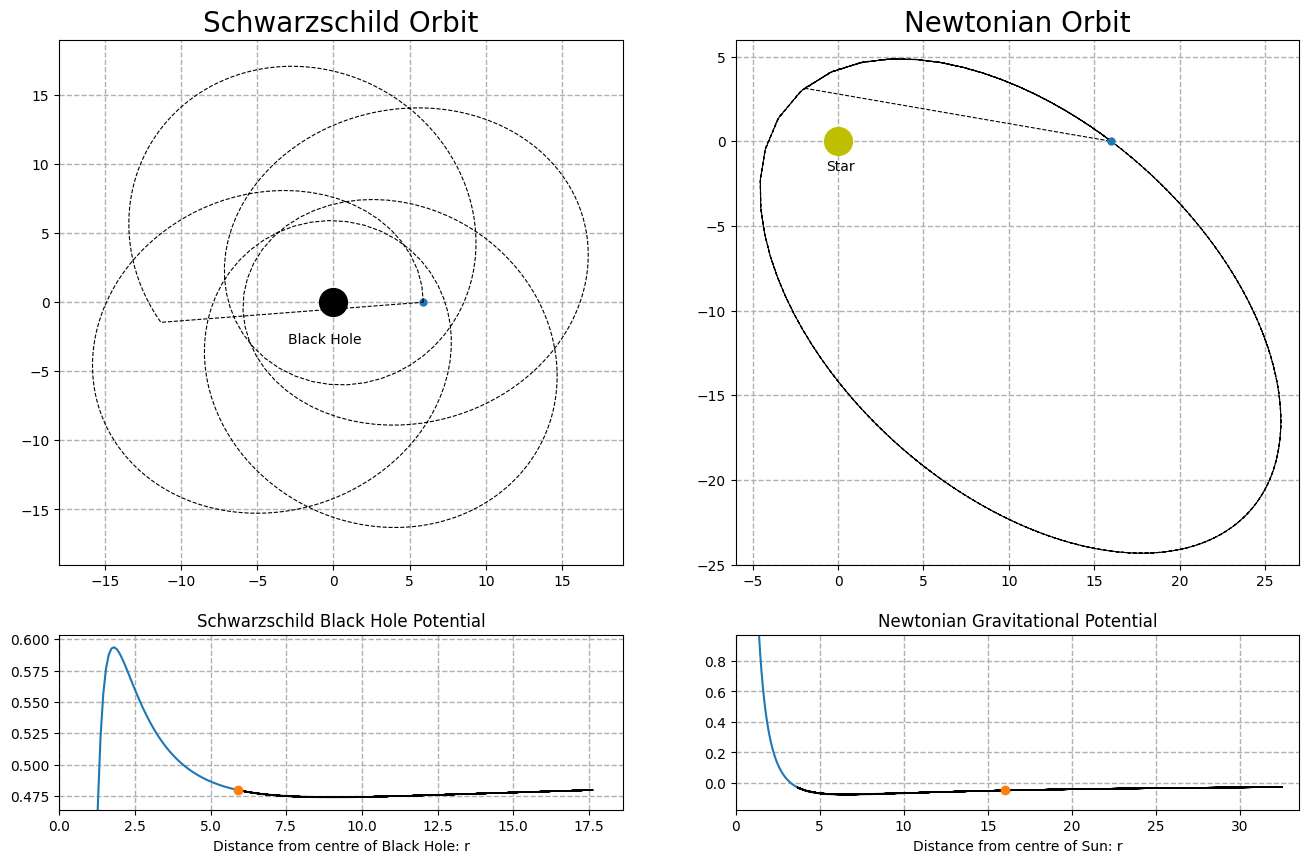

In [55]:
# Newton Initial Conditions

rn0 = 16
drn0 = -0.21
pn0 = 0
dpn0 = 0.01
Sn0 = [rn0, drn0, pn0, dpn0]

# Einstein Initial Conditions

delta = 0.17

r_s = 1
r0 = 5.9
dr0 = 0
p0 = 0
dp_circular = np.sqrt(1/(2*r0 - 3))/r0
dp0 = dp_circular*(1 + delta)
S0 = [r0, dr0, p0, dp0]
args = (r_s,)


ansn = integrate.odeint(func = dSndt, y0 = Sn0 ,t = t)
ans = integrate.odeint(func = dSdt, y0 = S0 ,t = t, args = args)

rnd = ansn.T[0]
drndtd = ansn.T[1]
phinad = ansn.T[2]
dphindtd = ansn.T[3]
xn = rnd*np.cos(phinad)
yn = rnd*np.sin(phinad)

rd = ans.T[0]
drdtd = ans.T[1]
thetad = ans.T[2]
dthetadtd = ans.T[3]
x = rd*np.cos(thetad)
y = rd*np.sin(thetad)

fig, ax = plt.subplots(2, 2, figsize = (16,10), gridspec_kw={'height_ratios': [3, 1]})

# ----- Orbital Motion ------

ax[0,0].set_facecolor('w')
ax[0,0].get_xaxis()
ax[0,0].get_yaxis()
ax[0,0].set_title('Schwarzschild Orbit', fontsize=20)
ax[0,0].grid(linestyle = '--', linewidth = 1)
ax[0,0].annotate("Black Hole ", (-3, -3))

xdata = []
ydata = []

ln1, = ax[0,0].plot([],[],'o', lw=3, markersize = 5)
ln2, = ax[0,0].plot([],[], '--',color = 'k', lw=0.8,)
ln3, = ax[0,0].plot([],[],'o',color = 'k', lw=3, markersize = 20)

ax[0,0].set_ylim(round(min(y)) - 1, round(max(y)) + 1)
ax[0,0].set_xlim(round(min(x)) - 1, round(max(y)) + 1)

# ----- Effective Pottential -----

l = (S0[0]**2)*S0[3]

x3 = np.linspace(1, 10, 100)
y3 = 1/2 + (l**2/(2*x3**2)) - (r_s)/(2*x3) - (r_s*l**2)/(2*x3**3)

x2 = rd
y2 = 1/2 + (l**2/(2*x2**2)) - (r_s)/(2*x2) - (r_s*l**2)/(2*x2**3)

ax[1,0].set_facecolor('w')
ax[1,0].get_xaxis()
ax[1,0].get_yaxis()
ax[1,0].set_xlabel('Distance from centre of Black Hole: r')
ax[1,0].set_title('Schwarzschild Black Hole Potential')
ax[1,0].grid(linestyle = '--', linewidth = 1)
ax[1,0].plot(x3,y3)

rdata = []
Vdata = []

ax[1,0].set_ylim(min(y2) - 0.01, max(y3) + 0.01)
ax[1,0].set_xlim(0, max(x2) + 1)

ln4, = ax[1,0].plot([], [], color = 'k', lw=1,)
ln5, = ax[1,0].plot([], [], 'o', lw=15,)

# ----- Newtonian ------

ax[0,1].set_facecolor('w')
ax[0,1].get_xaxis()
ax[0,1].get_yaxis()
ax[0,1].set_title('Newtonian Orbit', fontsize=20)
ax[0,1].grid(linestyle = '--', linewidth = 1)
ax[0,1].annotate("Star", (-0.7, -1.7))

xndata = []
yndata = []

ln7, = ax[0,1].plot([],[], '--',color = 'k', lw=0.8,)
ln6, = ax[0,1].plot([],[],'o', lw=3, markersize = 5)
ln8, = ax[0,1].plot([],[],'o',color = 'y', lw=3, markersize = 20)

ax[0,1].set_ylim(round(min(yn)) - 1, round(max(yn)) + 1)
ax[0,1].set_xlim(round(min(xn)) - 1, round(max(xn)) + 1)

# ----- Newtonian Potential -----

L = (Sn0[0]**2)*Sn0[3]

rn1 = np.linspace(1, 10, 100)
vn1 = (L**2)/(2*rn1**2) - 1/(rn1)

rn2 = rnd
vn2 = (L**2)/(2*rn2**2) - 1/(rn2)

ax[1,1].set_facecolor('w')
ax[1,1].get_xaxis()
ax[1,1].get_yaxis()
ax[1,1].set_xlabel('Distance from centre of Sun: r')
ax[1,1].set_title('Newtonian Gravitational Potential')
ax[1,1].grid(linestyle = '--', linewidth = 1)

ax[1,1].plot(rn1,vn1)

rndata = []
Vndata = []

ax[1,1].set_ylim(min(vn1) - 0.1, max(vn2) + 1)
ax[1,1].set_xlim(0, max(rn2) + 1)

ln9, = ax[1,1].plot([], [], color = 'k', lw=1,)
ln10, = ax[1,1].plot([], [], 'o', lw=15,)


def animate(i):
    rdata.append(x2[i])
    Vdata.append(y2[i])
    ln4.set_data(x2,y2)
    ln5.set_data(x2[i], y2[i])
    
    xdata.append(x[i])
    ydata.append(y[i])
    ln2.set_data(xdata, ydata)
    ln1.set_data([x[i]],[y[i]])
    ln3.set_data([0],[0])
    
    rndata.append(rn2[i])
    Vndata.append(vn2[i])
    ln9.set_data(rn2,vn2)
    ln10.set_data(rn2[i], vn2[i])
    
    xndata.append(xn[i])
    yndata.append(yn[i])
    ln7.set_data(xndata, yndata)
    ln6.set_data([xn[i]],[yn[i]])
    ln8.set_data([0],[0])
    

ani = animation.FuncAnimation(fig, animate, frames = 500, interval=800)
ani.save('trial3.gif', writer = 'pillow', fps = 25)